In [1]:
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt

import os.path as op
import sys
sys.path.append("../")

from src import regmod
from src import utils
from src import solver

import importlib

## Synthetic Example

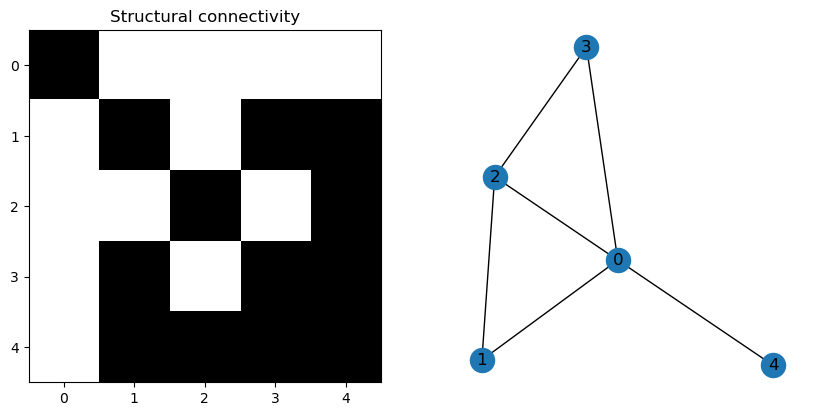

In [2]:
path_to_data = "../resources"

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

filename = "adjacency_synthetic.pkl"

adj = utils.load(op.join(path_to_data, filename))
adj -= np.diag(np.diag(adj))

axes[0].imshow(adj, cmap='gray')
axes[0].set_title('Structural connectivity')
toy_graph = nx.Graph(adj)
nx.draw(toy_graph, ax=axes[1], with_labels=True)

### Example of a forward pass

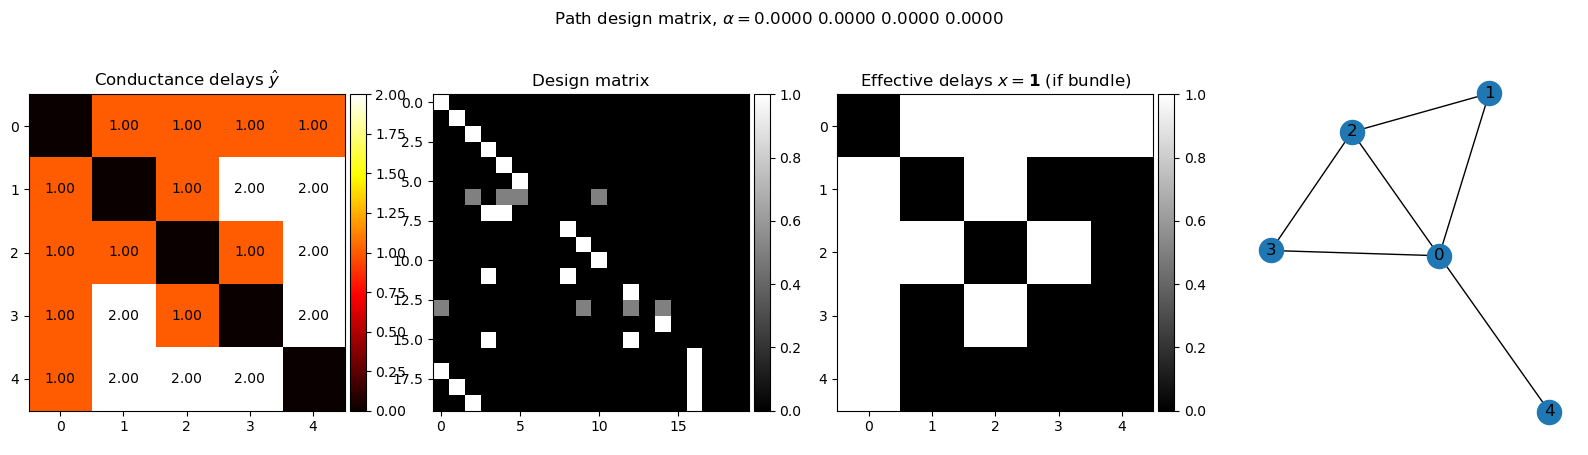

In [3]:
max_path_depth = 4

# multi_hops_design = regmod.get_path_matrices(adj, max_path_depth)

a = 0
# Computes the alpha vector as alpha_n = a^n
alpha = [a**(i+1) for i in range(max_path_depth)]
#alpha = a

# design_shortest = regmod.combine_paths_matrices(multi_hops_design, alpha=alpha)
design_shortest = regmod.build_design_shortest(adj, n_subopt=1, alpha=a)
design_model = design_shortest

y_pred_mat = regmod.predict_conduction_delays(design_model, adj, invert_weights=False)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(rf"Path design matrix, $\alpha=$"+" ".join([f"{a:1.4f}" for a in list(alpha)]))
axes[0].imshow(y_pred_mat, cmap='hot')
axes[0].set_title("Conductance delays $\hat{y}$")
utils.add_cbar(fig, axes[0])
utils.annotate_heatmap(fig, axes[0], y_pred_mat, adapt_color=0.6)

axes[1].imshow(design_model, cmap='gray')#, vmax=y_pred_mat.max())
axes[1].set_title("Design matrix")
utils.add_cbar(fig, axes[1])

axes[2].imshow(adj, cmap='gray')#, vmax=y_pred_mat.max())
axes[2].set_title("Effective delays $x=\mathbf{1}$ (if bundle)")
utils.add_cbar(fig, axes[2])

nx.draw(toy_graph, ax=axes[3], with_labels=True)

### Backward pass: Initialization with pseudo-inverse + iterative optimization

In [4]:
max_path_depth = 4

a = 0
alpha = [a**(i+1) for i in range(max_path_depth)]
#alpha = a

design_shortest = regmod.build_design_shortest(adj, n_subopt=1, alpha=a)
design_model = design_shortest

x_ground = utils.remove_diagonal_entries(adj).flatten()

alpha = solver.torch.tensor(alpha)

design_shortest = regmod.build_design_shortest(adj, n_subopt=1, alpha=a)
design_model = solver.torch.tensor(design_shortest)

y_pred = solver.forward(design_model, solver.torch.tensor(x_ground))
x_pseudo = solver.pseudo_inverse(y_pred.numpy(), a_design=design_model.numpy())

y_ground = solver.torch.tensor(utils.deepcopy(y_pred))
init_pseudo = False
if init_pseudo:
    x_init = solver.torch.tensor(x_pseudo).requires_grad_(True)
else:
    np.random.seed(99)
    x_init = solver.torch.tensor(np.random.rand(len(x_ground))).requires_grad_(True)

# alphas_init = solver.torch.tensor(np.random.rand(len(alpha))).requires_grad_(True)

/var/folders/nj/ltrlv15x5jj2jq78pbb2srz80000gn/T/ipykernel_21499/1241894738.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ground = solver.torch.tensor(utils.deepcopy(y_pred))


In [5]:
x = utils.deepcopy(x_init)
x_opt, loss = solver.gradient_descent_solver(x, y_ground, design_model,
                                            n_iter=1000, verbose=False, early_stop=1e-10, step_size=1e-2)

  0%|          | 0/1000 [00:00<?, ?it/s]

(<Figure size 1000x500 with 4 Axes>,
 <Axes: title={'center': 'Estimated Effective delays w/ loss=0.025'}>)

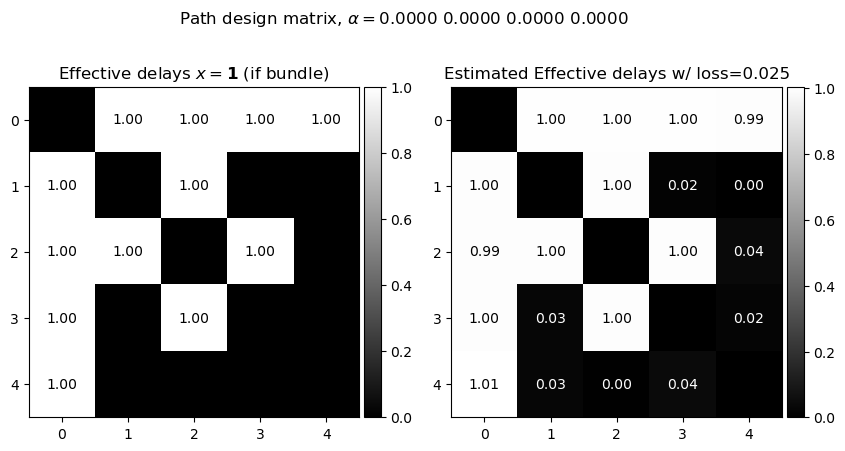

In [6]:
x_ground_mat = utils.add_diagonal_entries(x_ground.reshape(adj.shape[0], adj.shape[1]-1))
x_pred_mat = utils.add_diagonal_entries(x_opt.reshape(adj.shape[0], adj.shape[1]-1))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.suptitle(rf"Path design matrix, $\alpha=$"+" ".join([f"{a:1.4f}" for a in list(alpha)]))
axes[0].imshow(x_ground_mat, cmap='gray')
axes[0].set_title("Effective delays $x=\mathbf{1}$ (if bundle)")
utils.add_cbar(fig, axes[0])
utils.annotate_heatmap(fig, axes[0], x_ground_mat, adapt_color=0.6)

axes[1].imshow(x_pred_mat, cmap='gray')#, vmax=y_pred_mat.max())
axes[1].set_title(f"Estimated Effective delays w/ loss={np.round(loss,4)}")
utils.add_cbar(fig, axes[1])
# NOTE: we need to rechek this, it seems that the colors are flipped? (transposed?)
utils.annotate_heatmap(fig, axes[1], x_pred_mat.T, adapt_color=0.6)

## F-tract Example

Contents:
- Sanity check 
    - generating measured delay by considering only 1s delay for all bundles
    - verifying that the solver regresses back the only 1 delays

- Regressing conductance delays

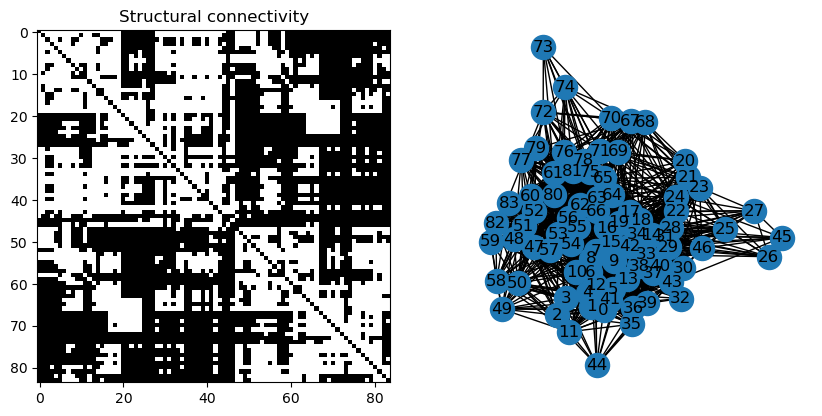

In [7]:
path_to_data = "../resources"

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

filename = "adjacency_atlas.pkl"

adj = utils.load(op.join(path_to_data, filename))
# TODO + NOTE: temporary truncation to remove (by michael)
adj = adj[:84, :84] 
adj -= np.diag(np.diag(adj))

axes[0].imshow(adj, cmap='gray')
axes[0].set_title('Structural connectivity')
toy_graph = nx.Graph(adj)
nx.draw(toy_graph, ax=axes[1], with_labels=True)

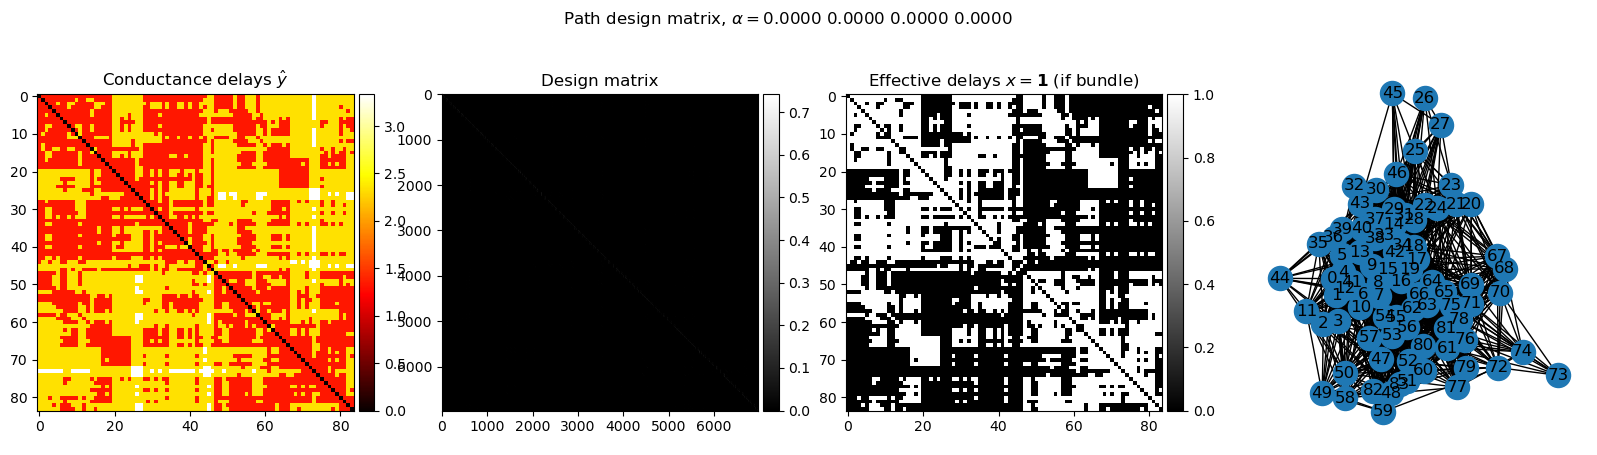

In [8]:
max_path_depth = 3

#multi_hops_design = regmod.get_path_matrices(adj, max_path_depth)

#a = 0
# Computes the alpha vector as alpha_n = a^n
#alpha = [a**(i+1) for i in range(max_path_depth)]
#alpha = a

#design_shortest = regmod.combine_paths_matrices(multi_hops_design, alpha=alpha)
design_shortest = regmod.build_design_shortest(adj, n_subopt=1, alpha=0.5)

y_pred_mat = regmod.predict_conduction_delays(design_shortest, adj, invert_weights=False)

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(rf"Path design matrix, $\alpha=$"+" ".join([f"{a:1.4f}" for a in list(alpha)]))
axes[0].imshow(y_pred_mat, cmap='hot', interpolation=None)
axes[0].set_title("Conductance delays $\hat{y}$")
utils.add_cbar(fig, axes[0])
#utils.annotate_heatmap(fig, axes[0], y_pred_mat, adapt_color=0.6)

axes[1].imshow(design_shortest, cmap='gray')#, vmax=y_pred_mat.max())
axes[1].set_title("Design matrix")
utils.add_cbar(fig, axes[1])

axes[2].imshow(adj, cmap='gray')#, vmax=y_pred_mat.max())
axes[2].set_title("Effective delays $x=\mathbf{1}$ (if bundle)")
utils.add_cbar(fig, axes[2])

nx.draw(toy_graph, ax=axes[3], with_labels=True)

### Sanity check

In [107]:
n_reduced = -1
reduced_adj = adj[:n_reduced][:, :n_reduced]

x_ground = utils.remove_diagonal_entries(reduced_adj).flatten()

a = 0.5
# Computes the alpha vector as alpha_n = a^n
alpha = solver.torch.tensor([a**(i+1) for i in range(max_path_depth)])

#design_model = solver.combine_paths_matrices_torch(solver.torch.tensor(multi_hops_design), alpha=alpha)

design_shortest = regmod.build_design_shortest(reduced_adj, n_subopt=1, alpha=a)
design_model = solver.torch.tensor(design_shortest)
x_ground = utils.remove_diagonal_entries(reduced_adj).flatten()
y_pred = solver.forward(design_model, solver.torch.tensor(x_ground)).numpy()

In [108]:
y_pred = solver.forward(design_model, solver.torch.tensor(x_ground))
y_ground = solver.torch.tensor(utils.deepcopy(y_pred))

init_pseudo = False
if init_pseudo:
    x_pseudo = solver.pseudo_inverse(y_pred.numpy(), a_design=design_model.numpy())
    x_init = solver.torch.tensor(x_pseudo).requires_grad_(True)
else:
    np.random.seed(99)
    x_init = solver.torch.tensor(np.random.rand(len(x_ground))).requires_grad_(True)

/var/folders/nj/ltrlv15x5jj2jq78pbb2srz80000gn/T/ipykernel_21499/2463974400.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ground = solver.torch.tensor(utils.deepcopy(y_pred))


In [109]:
## Checking for zero entries in the y vector (conduction delays)

non_zero_mask = y_ground > 0

y_masked = y_ground[non_zero_mask]
design_model_masked = design_model[non_zero_mask]

In [113]:
importlib.reload(solver)

x = utils.deepcopy(x_init)
x_opt, loss = solver.gradient_descent_solver(x, y_ground, design_model,
                                            n_iter=5000, verbose=False, 
                                            early_stop=1e-10, step_size=5e-2,
                                            l2_penalty=5e-1)

  0%|          | 0/5000 [00:00<?, ?it/s]

(<Figure size 1000x500 with 4 Axes>,
 <Axes: title={'center': 'Estimated Effective delays w/ loss=0.3287'}>)

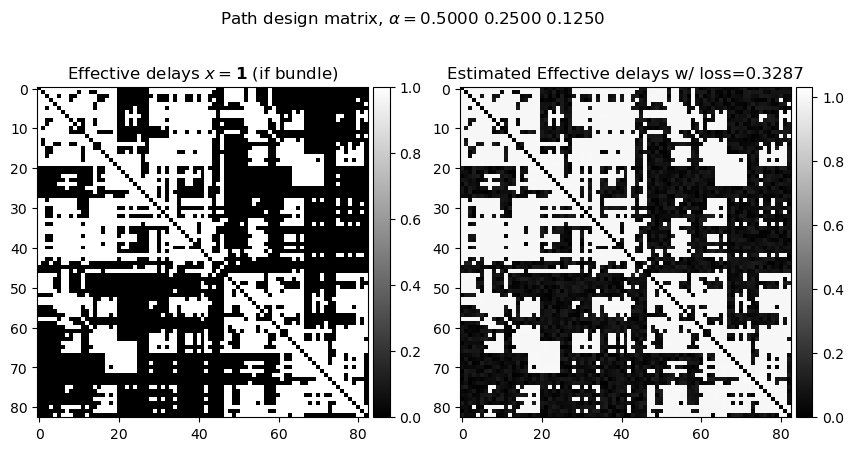

In [114]:
x_ground_mat = utils.add_diagonal_entries(x_ground.reshape(reduced_adj.shape[0], reduced_adj.shape[1]-1))
x_pred_mat = utils.add_diagonal_entries(x_opt.reshape(reduced_adj.shape[0], reduced_adj.shape[1]-1))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
fig.suptitle(rf"Path design matrix, $\alpha=$"+" ".join([f"{a:1.4f}" for a in list(alpha)]))
axes[0].imshow(x_ground_mat, cmap='gray')
axes[0].set_title("Effective delays $x=\mathbf{1}$ (if bundle)")
utils.add_cbar(fig, axes[0])
# utils.annotate_heatmap(fig, axes[0], x_ground_mat, adapt_color=0.6)

axes[1].imshow(x_pred_mat, cmap='gray')#, vmax=y_pred_mat.max())
axes[1].set_title(f"Estimated Effective delays w/ loss={np.round(loss,4)}")
utils.add_cbar(fig, axes[1])
# utils.annotate_heatmap(fig, axes[1], np.round(x_pred_mat,4), adapt_color=0.6)

Text(0.5, 0, 'Delay differences')

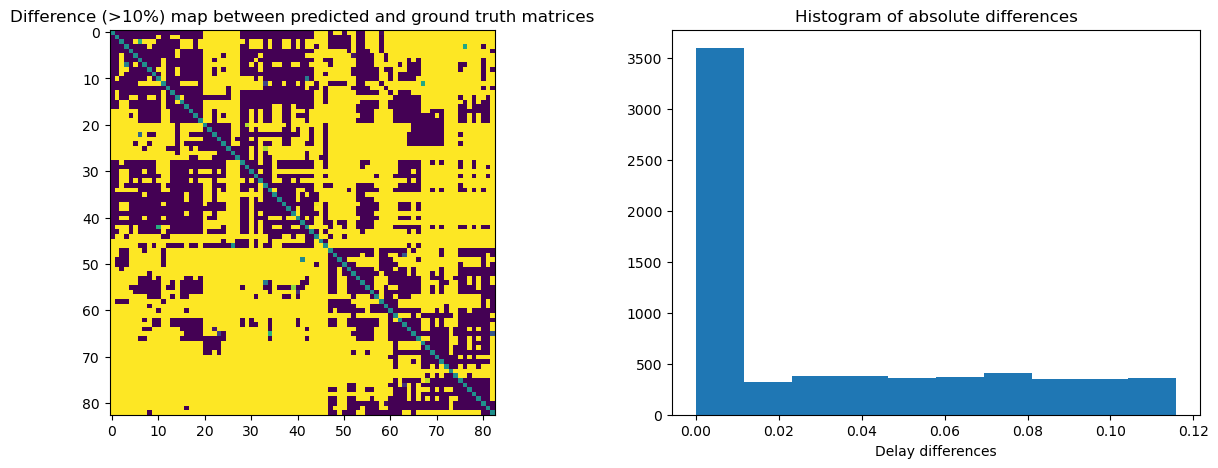

In [115]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
#ax.imshow(np.abs(x_pred_mat - x_ground_mat) > 0.1)
ax[0].imshow(x_pred_mat - x_ground_mat, vmin=-1e-5, vmax=1e-5)
ax[0].set_title('Difference (>10%) map between predicted and ground truth matrices')
ax[1].hist(np.abs(x_pred_mat - x_ground_mat).flatten())
ax[1].set_title('Histogram of absolute differences')
ax[1].set_xlabel('Delay differences')

### From conductance delay

In [117]:
n_reduced = -1

y_ground_mat = utils.load("../resources/conductance-delay_Lausanne2008_33.pkl")
y_ground_mat = np.nan_to_num(y_ground_mat['median'])[:n_reduced][:, :n_reduced]

y_ground = solver.torch.tensor(utils.remove_diagonal_entries(y_ground_mat).flatten())

In [118]:
max_path_depth = 3

adj_reduced = adj[:n_reduced][:, :n_reduced]

a = 1
# Computes the alpha vector as alpha_n = a^n
alpha = [a**(i+1) for i in range(max_path_depth)]

#design_model = solver.combine_paths_matrices_torch(solver.torch.tensor(multi_hops_design), alpha=alpha).numpy()
design_shortest = regmod.build_design_shortest(adj_reduced, n_subopt=1, alpha=a)
design_model = solver.torch.tensor(design_shortest)

In [119]:
## Checking for zero entries in the y vector (conduction delays)

non_zero_mask = y_ground > 0

y_masked = y_ground[non_zero_mask]
design_model_masked = design_model[non_zero_mask]

In [120]:
init_pseudo = False
if init_pseudo:
    x_pseudo = solver.pseudo_inverse(y_ground, a_design=design_model.numpy(), rcond=1e-10)
    x_init = solver.torch.tensor(x_pseudo).requires_grad_(True)
else:
    np.random.seed(99)
    x_init = solver.torch.tensor(np.random.rand(len(y_ground))).requires_grad_(True)

In [121]:
importlib.reload(solver)
x = utils.deepcopy(x_init)
x_opt, loss = solver.gradient_descent_solver(x, y_masked, design_model_masked,
                                            n_iter=20000, verbose=True, 
                                            early_stop=1e-10, step_size=5e-1,
                                            l2_penalty=1)

  0%|          | 0/20000 [00:00<?, ?it/s]

###### ITER 0 #######
datafit loss: 1575.37225675203
L2 norm: 47.83429872488418
positivity loss: 0.0

###### ITER 2000 #######
datafit loss: 1002.8279335363673
L2 norm: 429.7414132865502
positivity loss: 0.0

###### ITER 4000 #######
datafit loss: 747.0328892406029
L2 norm: 637.0710281741593
positivity loss: 0.0

###### ITER 6000 #######
datafit loss: 651.2357923407353
L2 norm: 723.2203964192887
positivity loss: 0.0

###### ITER 8000 #######
datafit loss: 615.4960606886215
L2 norm: 757.249645996822
positivity loss: 0.0

###### ITER 10000 #######
datafit loss: 601.3893579988995
L2 norm: 771.0491796740167
positivity loss: 0.0

Stopped at iteration #10814


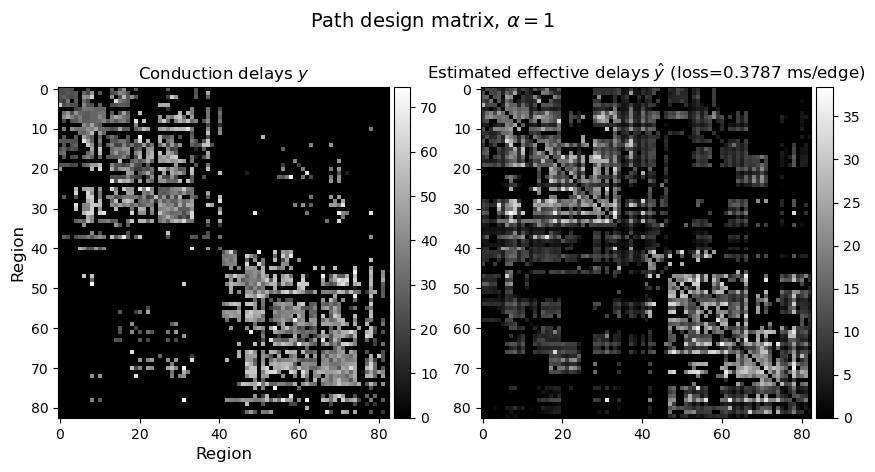

In [180]:
x_pred_mat = utils.add_diagonal_entries(x_opt.reshape(adj_reduced.shape[0], adj_reduced.shape[1]-1))

fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
fig.suptitle(rf"Path design matrix, $\alpha={a}$", fontsize=14)

axes[0].imshow(y_ground_mat, cmap='gray')
axes[0].set_title(f"Conduction delays $y$", fontsize=12)
axes[0].set_xlabel("Region", fontsize=12)
axes[0].set_ylabel("Region", fontsize=12)
utils.add_cbar(fig, axes[0])
# utils.annotate_heatmap(fig, axes, np.round(x_pred_mat,4), adapt_color=0.6)

prop_loss = loss / np.sum(y_ground_mat != 0)
axes[1].imshow(x_pred_mat, cmap='gray')
axes[1].set_title(f"Estimated effective delays $\hat y$ (loss={np.round(prop_loss,4)} ms/edge)", fontsize=12)
utils.add_cbar(fig, axes[1])

#axes[2].imshow(x_pred_mat, cmap='gray', vmin=0)
#axes[2].set_title(f"Clipped $\hat y$")
#utils.add_cbar(fig, axes[2])

fig.savefig(f"../figures/estimated_delays_a{a}.png", dpi=300)

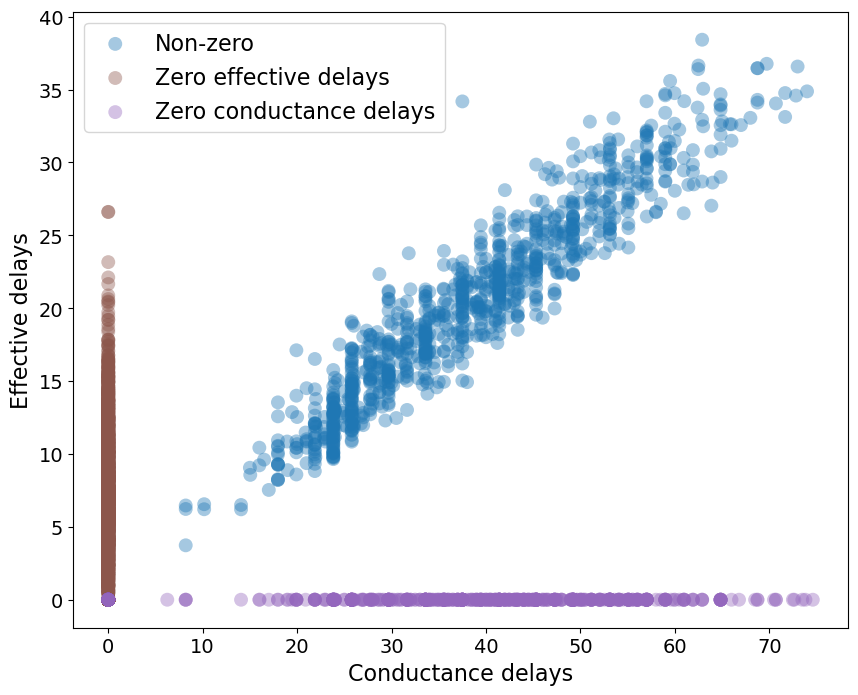

In [166]:
x = x_opt
y = y_ground

x_mask = x > 1e-5
y_mask = y != 0
xy_mask = np.logical_and(x_mask, y_mask).numpy().astype(bool)

fig, ax = plt.subplots(1,1, figsize=(10,8))

#plt.scatter(y[mymask], x[mymask])
ax.scatter(y[xy_mask], x[xy_mask], s=100, alpha=.4, edgecolors="none")
ax.scatter(y[~y_mask], x[~y_mask], s=100, alpha=.4, color="tab:brown", edgecolors="none")
ax.scatter(y[~x_mask], x[~x_mask], s=100, alpha=.4, color="tab:purple", edgecolors="none")

ax.set_xlabel("Conductance delays", fontsize=16)
ax.set_ylabel("Effective delays", fontsize=16)
ax.tick_params(labelsize=14)

ax.legend(["Non-zero", "Zero effective delays", "Zero conductance delays"], fontsize=16)

fig.savefig("../figures/scatter-effective_conductance.png", dpi=300)

tensor(75., dtype=torch.float64)


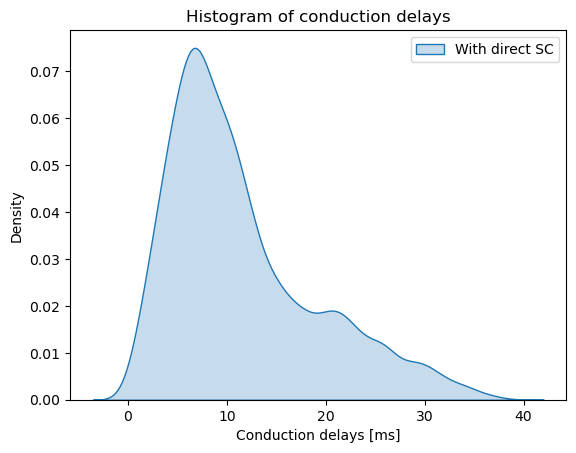

In [133]:
import seaborn as sns

cond_w_direct = x_opt[x_ground>0]
cond_wout_direct = x_opt[x_ground==0]

opt_bins = np.ceil(y_ground.max()) - np.floor(y_ground.min())
print(opt_bins)

nbins=np.arange(0, 100, 5)
nbins=np.arange(np.floor(y_ground.min()), np.ceil(y_ground.max()), 2)

sns.kdeplot(cond_w_direct[cond_w_direct>1e-5], bw_adjust=.8, fill=True, label='With direct SC')
sns.kdeplot(cond_wout_direct[cond_wout_direct>1e-5], bw_adjust=.8, fill=True, label='Without direct SC')

#plt.hist(cond_w_direct[cond_w_direct>0], bins=nbins, alpha=0.6, label='With direct SC')
#plt.hist(cond_wout_direct[cond_wout_direct>0], bins=nbins, alpha=0.6, label='Without direct SC')

plt.title("Histogram of conduction delays")
plt.xlabel("Conduction delays [ms]")
plt.legend()

#plt.savefig("../figures/hist_cond_delay.png")

#plt.boxplot([cond_w_direct[cond_w_direct>0], cond_wout_direct[cond_wout_direct>0]])
#plt.xticks([1, 2], ['Direct SC', 'No direct SC'])
#plt.ylabel('Conduction delays')

Text(0.5, 0, 'Delay differences')

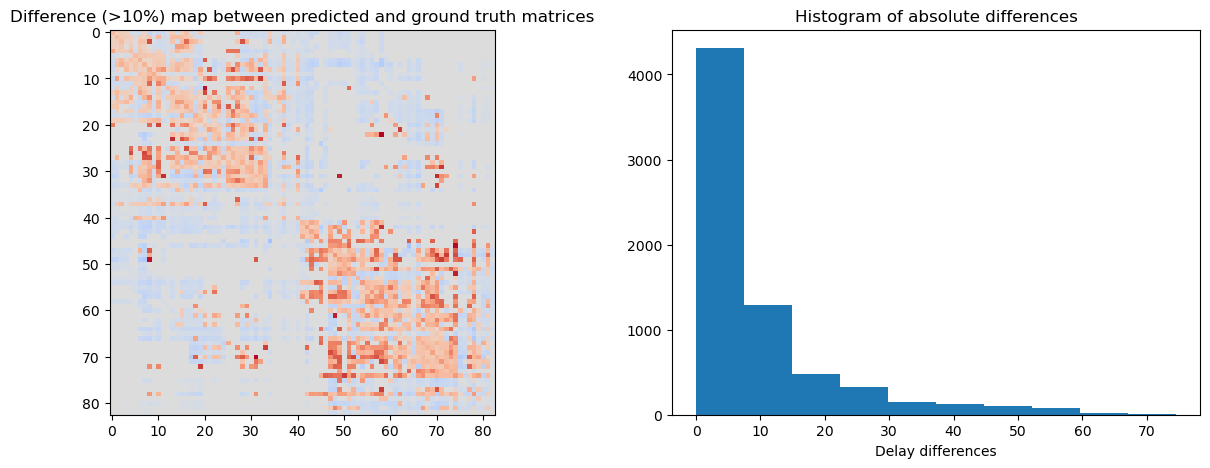

In [102]:
fig, ax = plt.subplots(1,2, figsize=(15,5))
#ax.imshow(np.abs(x_pred_mat - x_ground_mat) > 0.1)
diff = y_ground_mat - x_pred_mat
maxval = np.abs(diff).max()

ax[0].imshow(diff, vmin=-maxval, vmax=maxval, cmap="coolwarm")
ax[0].set_title('Difference (>10%) map between predicted and ground truth matrices')
ax[1].hist(np.abs(diff).flatten())
ax[1].set_title('Histogram of absolute differences')
ax[1].set_xlabel('Delay differences')

# Visualize the influence of $\alpha$

In [22]:
n_reduced = -1

y_ground_mat = utils.load("../resources/conductance-delay_Lausanne2008_33.pkl")
y_ground_mat = np.nan_to_num(y_ground_mat['median'])[:n_reduced][:, :n_reduced]

y_ground = solver.torch.tensor(utils.remove_diagonal_entries(y_ground_mat).flatten())

adj_reduced = adj[:n_reduced][:, :n_reduced]

n_alphas=10
alphas = np.linspace(0, 0.5, n_alphas)

losses = np.zeros_like(alphas)
all_sol = np.zeros((len(alphas), adj_reduced.shape[0], adj_reduced.shape[1]))

In [23]:
init_pseudo = False
for a_i, a in enumerate(alphas):
    if a == 0:
        design_model = solver.torch.tensor(regmod.build_design_shortest(adj_reduced, n_subopt=0, alpha=0))
    else:
        design_model = solver.torch.tensor(regmod.build_design_shortest(adj_reduced, n_subopt=1, alpha=a))

    if init_pseudo:
        x_pseudo = solver.pseudo_inverse(y_ground, a_design=design_model.numpy(), rcond=1e-10)
        x_init = solver.torch.tensor(x_pseudo).requires_grad_(True)
    else:
        np.random.seed(99)
        x_init = solver.torch.tensor(np.random.rand(len(y_ground))).requires_grad_(True)

    x = utils.deepcopy(x_init)
    x_opt, loss = solver.gradient_descent_solver(x, y_ground, design_model,
                                                n_iter=20000, verbose=False, 
                                                early_stop=1e-10, step_size=5e-1)
    all_sol[a_i] = utils.add_diagonal_entries(x_opt.reshape(adj_reduced.shape[0], adj_reduced.shape[1]-1))

    y_est = design_shortest @ x_opt
    losses[a_i] = np.linalg.norm(y_est - y_ground.numpy())

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 0/20000 [00:00<?, ?it/s]

(<Figure size 1800x500 with 5 Axes>,
 <Axes: title={'center': 'Clipped effective delays $x^*$ for $\\alpha=0.0$'}>)

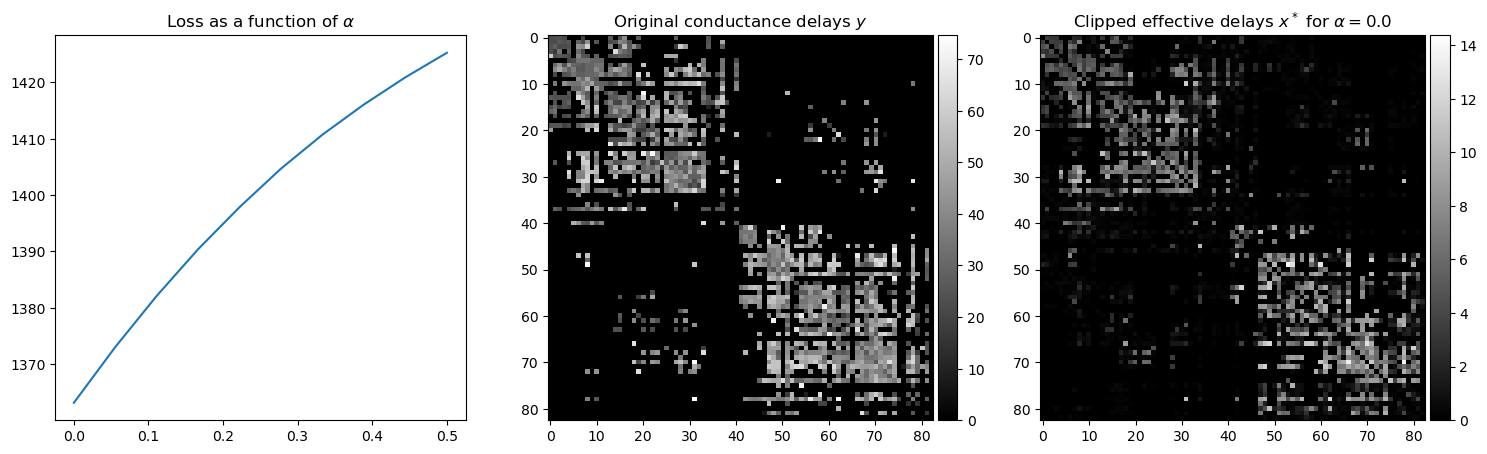

In [24]:
fig, axes = plt.subplots(ncols=3, figsize=(18, 5))

axes[0].plot(alphas, losses)
axes[0].set_title(r"Loss as a function of $\alpha$")

axes[1].imshow(y_ground_mat, cmap='gray')
axes[1].set_title(r"Original conductance delays $y$")
utils.add_cbar(fig, axes[1])

axes[2].imshow(all_sol[np.argmin(losses)], cmap='gray')
axes[2].set_title(rf"Clipped effective delays $x^*$ for $\alpha={alphas[np.argmin(losses)]}$")
utils.add_cbar(fig, axes[2])

In [25]:
utils.save("regressed_effective_delay_norm.pkl",{'alphas': alphas,
                                            'losses': losses,
                                            'eff_delay': all_sol})

(<Figure size 1800x500 with 6 Axes>,
 <Axes: title={'center': 'Clipped effective delays $x^*$ for $\\alpha=0.5$'}>)

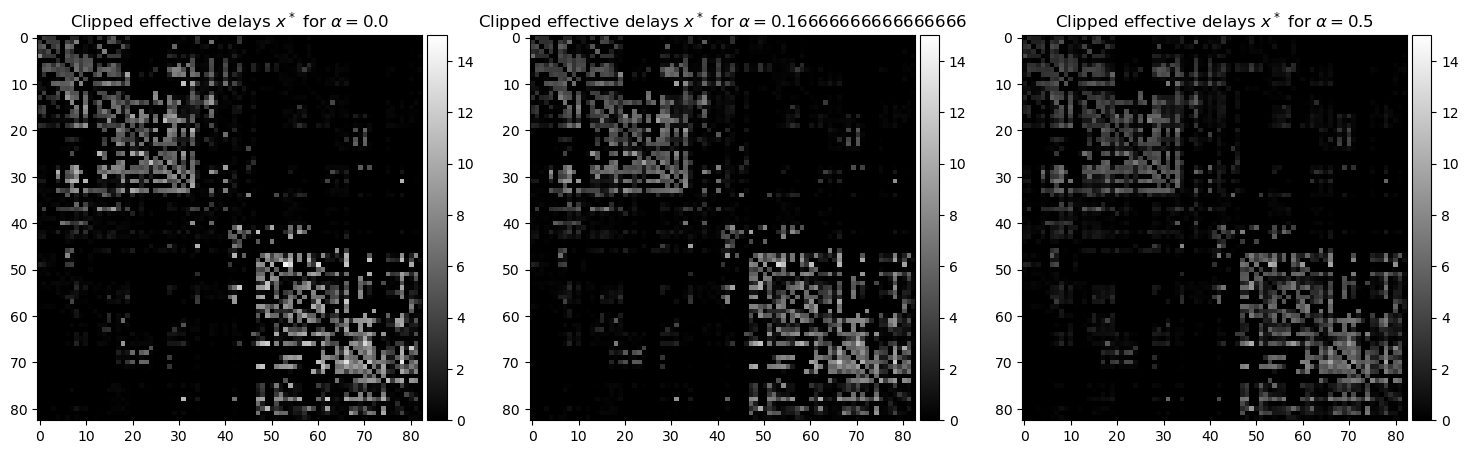

In [40]:
fig, axes = plt.subplots(ncols=3, figsize=(18, 5))

axes[0].imshow(all_sol[np.argmin(losses)], cmap='gray', vmin=0, vmax=15)
axes[0].set_title(rf"Clipped effective delays $x^*$ for $\alpha={alphas[np.argmin(losses)]}$")
utils.add_cbar(fig, axes[0])

a_mid = 3
axes[1].imshow(all_sol[a_mid], cmap='gray', vmin=0, vmax=15)
axes[1].set_title(rf"Clipped effective delays $x^*$ for $\alpha={alphas[a_mid]}$")
utils.add_cbar(fig, axes[1])

axes[2].imshow(all_sol[-1], cmap='gray', vmin=0, vmax=15)
axes[2].set_title(rf"Clipped effective delays $x^*$ for $\alpha={alphas[-1]}$")
utils.add_cbar(fig, axes[2])

Text(0, 0.5, 'Effective delays')

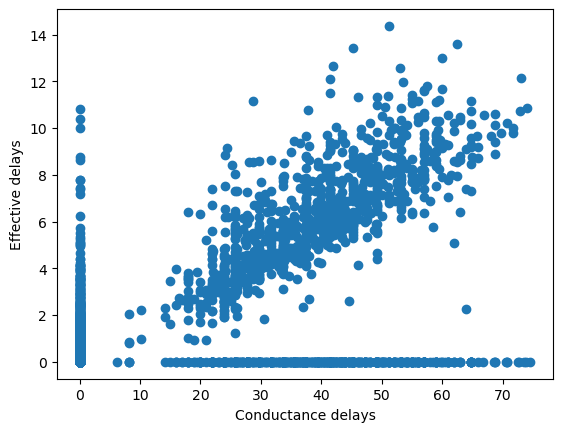

In [60]:
x = all_sol[0].flatten()
y = y_ground_mat.flatten()

mymask = np.logical_and(x > 1e-5, y != 0)
mymask = y != 0

#plt.scatter(y[mymask], x[mymask])
plt.scatter(y, x)
plt.xlabel("Conductance delays")
plt.ylabel("Effective delays")

In [68]:
print("proportion of 0 in conductance delay", sum(y == 0)/len(y))
print("proportion of 0 in conductance delay", np.logical_and(y==0, x<1e-5).sum()/len(y))

proportion of 0 in conductance delay 0.77064886050225
proportion of 0 in conductance delay 0.4552184642183191


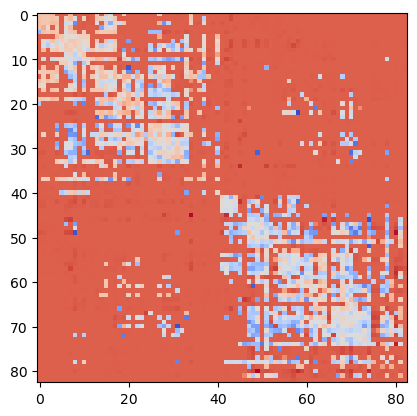

In [62]:
thresh = np.percentile(y_ground_mat, 90)

plt.imshow(all_sol[0] - y_ground_mat, cmap="coolwarm")